<a href="https://colab.research.google.com/github/thirumalvenkat/customermarketing/blob/master/bank_product_reco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pandas-profiling
!pip install lime

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for lime: filename=lime-0.1.1.37-cp36-none-any.whl size=284277 sha256=6d46ea4d756c5212edc9976abb69071b3be0a852a6e4b0d94a25d073d0539259
  Stored in directory: /root/.cache/pip/wheels/c1/38/e7/50d75d4fb75afa604570dc42f20c5c5f5ab26d3fbe8d6ef27b
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12074 sha256=3a94153c1636353243a9a503ceba7bc568859c60d6eeeedff0deeb45e2e1ce39
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built lime progressbar


In [0]:
# ONLY RUN IF YOU ARE IN A COLAB NOTEBOOK.
from google.colab import auth
auth.authenticate_user()

In [0]:
%env GOOGLE_CLOUD_PROJECT=stately-planet-181816

env: GOOGLE_CLOUD_PROJECT=stately-planet-181816


In [0]:
!gcloud config set project $GOOGLE_CLOUD_PROJECT

Updated property [core/project].


In [0]:
!gcloud services enable ml.googleapis.com
!gcloud services enable bigquery-json.googleapis.com

In [0]:
import os
your_dataset = 'bank_reco'
your_table = 'bank_deposit_pred'
project_id = os.environ["GOOGLE_CLOUD_PROJECT"]

In [0]:
!curl https://storage.googleapis.com/erwinh-public-data/bankingdata/bank-full.csv --output banking_deposit_pred_data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4502k  100 4502k    0     0  10.1M      0 --:--:-- --:--:-- --:--:-- 10.1M


In [0]:
!bq load --autodetect --source_format=CSV --field_delimiter ';' --skip_leading_rows=1 --replace {your_dataset}.{your_table} banking_deposit_pred_data.csv


Welcome to BigQuery! This script will walk you through the 
process of initializing your .bigqueryrc configuration file.

First, we need to set up your credentials if they do not 
already exist.

Credential creation complete. Now we will select a default project.

List of projects:
  #         projectId            friendlyName    
 --- ------------------------ ------------------ 
  1   customer-support-bac47   Customer-Support  
  2   ind-coe                  IND COE           
  3   silicon-stock-246208     NextBestAction    
  4   stately-planet-181816    thirumal-gcp-coe  
Found multiple projects. Please enter a selection for 
which should be the default, or leave blank to not 
set a default.

Enter a selection (1 - 4): 4

BigQuery configuration complete! Type "bq" to get started.

Upload complete.
Waiting on bqjob_r2feca19358c254ac_00000171160d7443_1 ... (2s) Current status: DONE   


### **01 - Fetching data**

In [0]:
#import pandas and bigquery library

import pandas as pd
from google.cloud import bigquery as bq

In [0]:
# Execute the query and converts the result into a Dataframe

client = bq.Client(project=project_id)
df = client.query('''
  SELECT
    *
  FROM
    `%s.%s`
''' % (your_dataset, your_table)).to_dataframe()

df.head(3).T

,0,1,2
age,42,56,44
job,admin.,admin.,admin.
marital,single,married,married
education,secondary,secondary,secondary
default,False,False,False
balance,-247,1270,4826
housing,True,True,True
loan,True,False,False
contact,telephone,cellular,cellular
day,21,17,17


## **02 - Data Exploration**

In [0]:
import pandas_profiling as pp

In [0]:
#pp.ProfileReport(df)

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

#Here we apply a shuffle and stratified split to create a train and test set.
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=40)
for train_index, test_index in split.split(df, df["y"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

## 03 - Feature Engineering

In [0]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [0]:
def return_features_and_label(df):
    """returns features and label given argument dataframe"""
    
    # Get all the columns except "y". It's also possible to exclude other columns
    X = df.drop("y", axis=1)
    
    Y = df["y"].copy ()
    # Convert our label to an integer
    Y = LabelEncoder().fit_transform(Y) 
    return X, Y

In [0]:
def data_pipeline(df):
    """Normalizes and converts data and returns dataframe """
  
    num_cols = df.select_dtypes(include=np.number).columns
    cat_cols = list(set(df.columns) - set(num_cols))
    # Normalize Numeric Data
    df[num_cols] = StandardScaler().fit_transform(df[num_cols])
    # Convert categorical variables to integers
    df[cat_cols] = df[cat_cols].apply(LabelEncoder().fit_transform)
    return df

In [0]:
new_num_cols = train_features.select_dtypes(include=np.number).columns
new_num_cols

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

In [0]:
list(set(train_features.columns) - set(new_num_cols))

['month',
 'housing',
 'job',
 'default',
 'marital',
 'poutcome',
 'contact',
 'education',
 'loan']

In [0]:
train_features, train_label = return_features_and_label(strat_train_set)

In [0]:
train_features_prepared = data_pipeline(train_features)

In [0]:
train_features_prepared.head(3).T

,14217,27492,18251
age,-0.271979,1.326772,-0.648155
job,8.000000,9.000000,7.000000
marital,2.000000,1.000000,2.000000
education,3.000000,1.000000,1.000000
default,0.000000,0.000000,0.000000
balance,-0.207265,-0.351958,0.876312
housing,0.000000,1.000000,1.000000
loan,0.000000,0.000000,1.000000
contact,2.000000,2.000000,0.000000
day,0.267121,-0.455160,-0.094020


In [0]:
from sklearn.feature_selection import SelectKBest, f_classif  

predictors = train_features_prepared.columns

# Perform feature selection where `k` (5 in this case) indicates the number of features we wish to select
selector = SelectKBest(f_classif, k=5)
selector.fit(train_features_prepared[predictors], train_label)

SelectKBest(k=5, score_func=<function f_classif at 0x7f8c61d13bf8>)

In [0]:
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


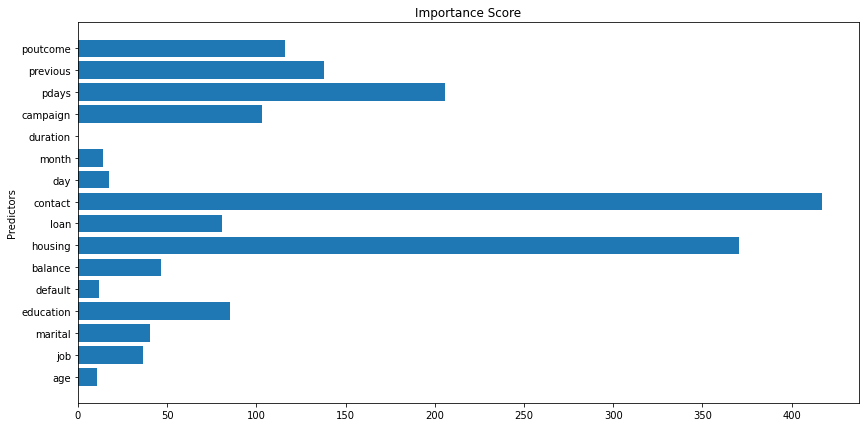

In [0]:
# Get the p-values from our selector for each model and convert to a logarithmic scale for easy vizualization
importance_score = -np.log(selector.pvalues_)

# Plot each column with their importance score
plt.rcParams["figure.figsize"] = [14,7]
plt.barh(range(len(predictors)), importance_score, color='C0')
plt.ylabel("Predictors")
plt.title("Importance Score")
plt.yticks(range(len(predictors)), predictors)

plt.show()

In [0]:
# Example of how to use a Tree classifier to select best features. 

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel    

predictors_tree = train_features_prepared.columns

selector_clf = ExtraTreesClassifier(n_estimators=50, random_state=0)
selector_clf.fit(train_features_prepared[predictors], train_label)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
                     oob_score=False, random_state=0, verbose=0,
                     warm_start=False)

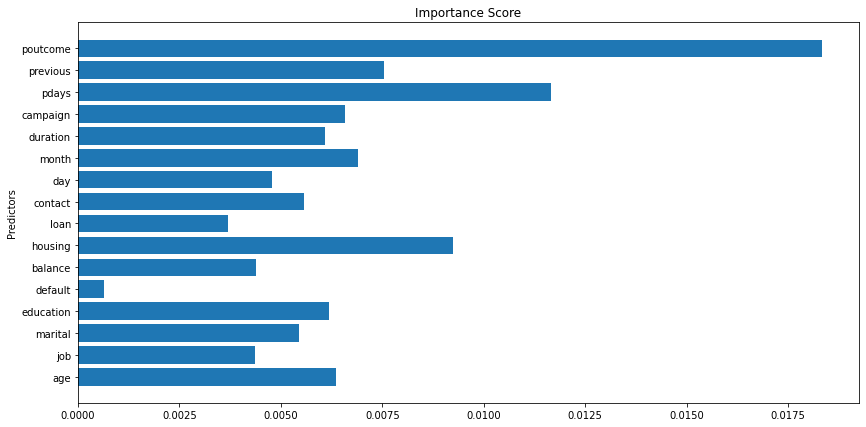

In [0]:
# Plotting feature importance

importances = selector_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in selector_clf.estimators_],
             axis=0)

plt.rcParams["figure.figsize"] = [14,7]
plt.barh(range(len(predictors_tree)), std, color='C0')
plt.ylabel("Predictors")
plt.title("Importance Score")
plt.yticks(range(len(predictors_tree)), predictors_tree)

plt.show()

In [0]:
# Plot the top 5 features based on the Log Score that we calculated earlier.  
train_prepared_indexs = [count for count, selected in enumerate(selector.get_support()) if selected == True]

pd.DataFrame(
    {'Feature' : predictors[train_prepared_indexs],
     'Original Score': selector.pvalues_[train_prepared_indexs],
     'Log Score' : importance_score[train_prepared_indexs]
    }
)

,Feature,Original Score,Log Score
0,housing,1.375125e-161,370.397656
1,contact,7.567334e-182,417.046646
2,duration,0.000000e+00,inf
3,pdays,3.376512e-90,206.015815
4,previous,1.223846e-60,137.953107


In [0]:
train_prepared_indexs

[6, 8, 11, 13, 14]

ERROR! Session/line number was not unique in database. History logging moved to new session 59


In [0]:
# Here we are creating our new dataframe based on the selected features (from selector)
train_prepared_columns = [col for (selected, col) in zip(selector.get_support(), predictors) if selected == True]
train_prepared = train_features_prepared[train_prepared_columns]

In [0]:
train_prepared_columns

['housing', 'contact', 'duration', 'pdays', 'previous']

## 05 - Building the model

In [0]:
# Importing libraries needed

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve


import matplotlib.pyplot as plt
import numpy as np

In [0]:
# this function will create the classifiers (models) that we want to test
def create_classifiers(): 
    """Create classifiers and specify hyper parameters"""
    
    log_params = [{'penalty': ['l1', 'l2'], 'C': np.logspace(0, 4, 10)}]

    knn_params = [{'n_neighbors': [3, 4, 5]}]

    svc_params = [{'kernel': ['linear', 'rbf'], 'probability': [True]}]

    tree_params = [{'criterion': ['gini', 'entropy']}]

    forest_params = {'n_estimators': [1, 5, 10]}

    mlp_params = {'activation': [
                    'identity', 'logistic', 'tanh', 'relu'
                  ]}

    ada_params = {'n_estimators': [1, 5, 10]}

    classifiers = [
        ['LogisticRegression', LogisticRegression(random_state=42),
         log_params],
        ['KNeighborsClassifier', KNeighborsClassifier(), knn_params],
        ['SVC', SVC(random_state=42), svc_params],
        ['DecisionTreeClassifier',
         DecisionTreeClassifier(random_state=42), tree_params],
        ['RandomForestClassifier',
         RandomForestClassifier(random_state=42), forest_params],
        ['MLPClassifier', MLPClassifier(random_state=42), mlp_params],
        ['AdaBoostClassifier', AdaBoostClassifier(random_state=42),
         ada_params],
        ]

    return classifiers


In [0]:
# this grid search will iterate through the different combinations and returns the best parameters for each model type. 
# Running this cell might take a while

def grid_search(model, parameters, name,training_features, training_labels):
    """Grid search that returns best parameters for each model type"""
    
    clf = GridSearchCV(model, parameters, cv=3, refit = 'f1',
                       scoring='f1', verbose=0, n_jobs=4)
    clf.fit(training_features, training_labels)
    best_estimator = clf.best_estimator_
  
    return [name, str(clf.best_params_), clf.best_score_,
            best_estimator]

In [0]:
# Now we want to get the best configuration for each model. 

def best_configuration(classifiers, training_features, training_labels):
    """returns the best configuration for each model"""
    
    clfs_best_config = []

    for (name, model, parameters) in classifiers:
        clfs_best_config.append(grid_search(model, parameters, name,
                                training_features, training_labels))
    return clfs_best_config

In [0]:
# Here we call the Grid search and Best_configuration function (note we only use 100 rows to decrease the run time). 

import warnings
warnings.filterwarnings('ignore')

classifiers = create_classifiers()
clfs_best_config = best_configuration(classifiers, train_prepared[:100], train_label[:100])

In [0]:
# Prepare the test data for prediction
test_features, test_label = return_features_and_label(strat_test_set)
test_features_prepared = data_pipeline(test_features)
test_prepared = test_features_prepared[train_prepared_columns]

In [0]:
f1_score_list = []
accuracy_list = []
precision_list = []
recall_list = []
roc_auc_list = []
model_name_list = []

# Iterate through the different model combinations to calculate perf. metrics.

for name, params, score, model in clfs_best_config:
    pred_label = model.predict(test_prepared) # Predict outcome.
    f1_score_list.append(f1_score(test_label,pred_label)) # F1 score.
    accuracy_list.append(accuracy_score(test_label, pred_label)) # Accuracy score.
    precision_list.append(precision_score(test_label, pred_label)) # Precision score.
    recall_list.append(recall_score(test_label, pred_label)) # Recall score.
    roc_auc_list.append(roc_auc_score(test_label,
                        model.predict_proba(test_prepared)[:, 1]))  # Predict probability.
    model_name_list.append(name)

# Sum up metrics in a pandas data frame.
pd.DataFrame(
    {'Model' : model_name_list,
     'F1 Score' : f1_score_list,
     'Accurary': accuracy_list,
     'Precision': precision_list,
     'Recall': recall_list,
     'Roc_Auc': roc_auc_list 
    },
    columns = ['Model','F1 Score','Precision','Recall', 'Accurary', 'Roc_Auc']
)

,Model,F1 Score,Precision,Recall,Accurary,Roc_Auc
0,LogisticRegression,0.314028,0.491935,0.230624,0.882119,0.835507
1,KNeighborsClassifier,0.366525,0.416867,0.327032,0.867743,0.712208
2,SVC,0.364063,0.480620,0.293006,0.880239,0.841476
3,DecisionTreeClassifier,0.334408,0.326146,0.343100,0.840208,0.624587
4,RandomForestClassifier,0.292842,0.343511,0.255198,0.855800,0.729608
5,MLPClassifier,0.331894,0.477798,0.254253,0.880239,0.812670
6,AdaBoostClassifier,0.449021,0.479100,0.422495,0.878691,0.810856


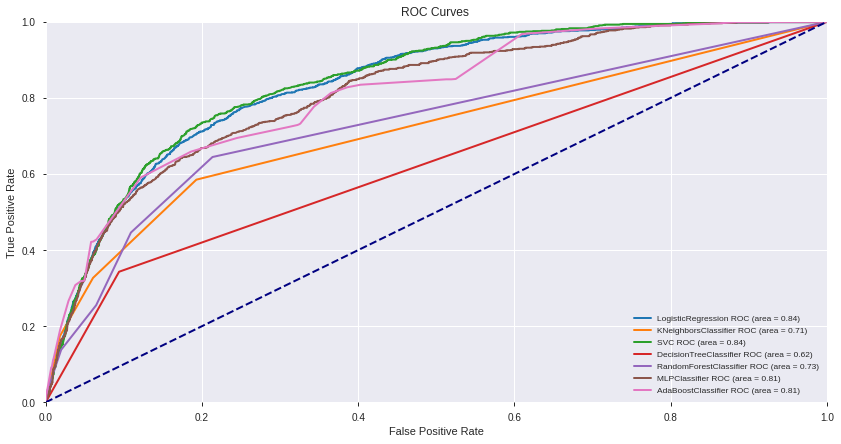

In [0]:
# Create a function that plots an ROC curve
def roc_graph(test_label, pred_label, name):
  """Plots the ROC curve's in a Graph"""
  
  fpr, tpr, thresholds = roc_curve(test_label, pred_label, pos_label=1)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, lw=2, label='%s ROC (area = %0.2f)' % (name, roc_auc))

plt.clf()

# Iterate though the models, create ROC graph for each model.
for name, _, _, model in clfs_best_config:
    pred_label = model.predict_proba(test_prepared)[:,1]
    roc_graph(test_label, pred_label, name)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves ')
plt.legend(loc="lower right", fontsize='small')
plt.show()

In [0]:
%env GCS_BUCKET=gs://thirude
%env REGION=us-central1
%env LOCAL_DIRECTORY=./trainer/data
%env TRAINER_PACKAGE_PATH=./trainer

env: GCS_BUCKET=gs://thirude
env: REGION=us-central1
env: LOCAL_DIRECTORY=./trainer/data
env: TRAINER_PACKAGE_PATH=./trainer


In [0]:
%%bash
mkdir trainer
touch trainer/__init__.py

In [0]:
!echo $GCS_BUCKET

gs://thirude


In [0]:
strat_train_set.to_csv('train.csv', index=None)
!gsutil cp train.csv $GCS_BUCKET

Copying file://train.csv [Content-Type=text/csv]...
/ [1 files][  3.2 MiB/  3.2 MiB]                                                
Operation completed over 1 objects/3.2 MiB.                                      


In [0]:
!gsutil ls $GCS_BUCKET

gs://thirude/Recommendations.ipynb
gs://thirude/SCB_POC.ipynb
gs://thirude/ga_bank_sessions
gs://thirude/input.json
gs://thirude/next_best_prep_data
gs://thirude/next_best_prep_data.csv
gs://thirude/train.csv
gs://thirude/access_cred/
gs://thirude/banking_200324_091313/
gs://thirude/banking_200324_091407/
gs://thirude/banking_200324_100413/
gs://thirude/banking_200324_101835/
gs://thirude/custom_prediction_routine_tutorial/
gs://thirude/model_20200324_102011/
gs://thirude/test/


In [0]:
%%writefile trainer/task.py

import datetime
import os
import pandas as pd
import numpy as np
import subprocess

from google.cloud import storage

from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# TODO: REPLACE '<BUCKET_NAME>' with your GCS bucket name
BUCKET_NAME ='thirude'

# Bucket holding the training data
bucket = storage.Client().bucket(BUCKET_NAME)

# Path to the data inside the  bucket
blob = bucket.blob('train.csv')
# Download the data
blob.download_to_filename('train.csv')
# [END download-data]

# [START scikit-learn code]
# Load the training dataset
with open('./train.csv', 'r') as train_data:
    df = pd.read_csv(train_data)

def return_features_and_label(df_tmp):
    # Get all the columns except the one named "y"
    X = df_tmp.drop("y", axis=1)
    Y = df_tmp["y"].copy()
    # Convert label to an integer
    Y = LabelEncoder().fit_transform(Y)
    return X, Y

def data_pipeline(df_tmp):
    num_cols = df_tmp._get_numeric_data().columns
    cat_cols = list(set(df_tmp.columns) - set(num_cols))
    # Normalize Numeric Data
    df_tmp[num_cols] = StandardScaler().fit_transform(df_tmp[num_cols])
    # Convert categorical variables to integers
    df_tmp[cat_cols] = df_tmp[cat_cols].apply(LabelEncoder().fit_transform)
    return df_tmp

def create_classifiers():
    log_params = [{'penalty': ['l1', 'l2'], 'C': np.logspace(0, 4, 10)}]

    knn_params = [{'n_neighbors': [3, 4, 5]}]

    svc_params = [{'kernel': ['linear', 'rbf'], 'probability': [True]}]

    tree_params = [{'criterion': ['gini', 'entropy']}]

    forest_params = {'n_estimators': [1, 5, 10]}

    mlp_params = {'activation': [
                    'identity', 'logistic', 'tanh', 'relu'
                  ]}

    ada_params = {'n_estimators': [1, 5, 10]}

    classifiers = [
        ['LogisticRegression', LogisticRegression(random_state=42),
         log_params],
        ['KNeighborsClassifier', KNeighborsClassifier(), knn_params],
        ['SVC', SVC(random_state=42), svc_params],
        ['DecisionTreeClassifier',
         DecisionTreeClassifier(random_state=42), tree_params],
        ['RandomForestClassifier',
         RandomForestClassifier(random_state=42), forest_params],
        ['MLPClassifier', MLPClassifier(random_state=42), mlp_params],
        ['AdaBoostClassifier', AdaBoostClassifier(random_state=42),
         ada_params],
        ]

    return classifiers


def grid_search(model, parameters, name, X, y):
    clf = GridSearchCV(model, parameters, cv=3, refit = 'f1',
                       scoring='f1', verbose=0, n_jobs=4)
    clf.fit(X, y)
    best_estimator = clf.best_estimator_
  
    return [name, clf.best_score_, best_estimator]


def best_configuration(classifiers, training_values, testing_values):
    clfs_best_config = []
    best_clf = None
    best_score = 0

    for (name, model, parameters) in classifiers:
        clfs_best_config.append(grid_search(model, parameters, name,
                                training_values, testing_values))
    
    for name, quality, clf in clfs_best_config:
        if quality > best_score:
            best_score = quality
            best_clf = clf
    
    return best_clf


train_features, train_label = return_features_and_label(df)
train_features_prepared = data_pipeline(train_features)

predictors = train_features_prepared.columns
# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(train_features_prepared[predictors], train_label)

train_prepared_columns = [col for (selected, col) in zip(selector.get_support(), predictors) if selected == True]
train_features_prepared = train_features_prepared[train_prepared_columns]


x = train_features_prepared.values
y = train_label
classifiers = create_classifiers()
clf = best_configuration(classifiers, x[:100], y[:100])
# [END scikit-learn]


# [START export-to-gcs]
# Export the model to a file
model = 'model.joblib'
joblib.dump(clf, model)

# Upload the model to GCS
bucket = storage.Client().bucket(BUCKET_NAME)
blob = bucket.blob('{}/{}'.format(
    datetime.datetime.now().strftime('model_%Y%m%d_%H%M%S'),
    model))
blob.upload_from_filename(model)
# [END export-to-gcs]

Writing trainer/task.py


In [0]:
%%bash 

JOBNAME=banking_$(date -u +%y%m%d_%H%M%S)

echo $JOBNAME 

gcloud ai-platform jobs submit training model_training_$JOBNAME \
        --job-dir $GCS_BUCKET/$JOBNAME/output \
        --package-path trainer \
        --module-name trainer.task \
        --region $REGION \
        --runtime-version=1.15 \
        --python-version=3.5 \
        --scale-tier BASIC

banking_200326_085548
jobId: model_training_banking_200326_085548
state: QUEUED


Job [model_training_banking_200326_085548] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe model_training_banking_200326_085548

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs model_training_banking_200326_085548


In [0]:
!ls trainer/

__init__.py  task.py


In [0]:
test_features_prepared = data_pipeline(test_features)
test_prepared = test_features_prepared[train_prepared_columns]
test = test_prepared.as_matrix().tolist()

In [0]:
test_prepared

,housing,contact,duration,pdays,previous
26627,0.895206,-0.714286,1.716581,-0.416098,-0.317155
804,-1.117061,-0.714286,-0.620077,3.027578,1.315500
17565,-1.117061,0.398234,-0.426344,-0.416098,-0.317155
5035,0.895206,-0.714286,0.625350,-0.055714,1.859718
7134,0.895206,-0.714286,0.645119,0.504885,3.492372
...,...,...,...,...,...
22136,0.895206,-0.714286,-0.027017,-0.416098,-0.317155
13546,0.895206,-0.714286,1.791702,-0.416098,-0.317155
2043,0.895206,-0.714286,-0.754505,2.927471,0.227063
1825,-1.117061,-0.714286,0.214161,0.554938,0.771282


In [0]:
test

In [0]:
!gsutil ls $GCS_BUCKET

gs://thirude/Recommendations.ipynb
gs://thirude/SCB_POC.ipynb
gs://thirude/ga_bank_sessions
gs://thirude/input.json
gs://thirude/next_best_prep_data
gs://thirude/next_best_prep_data.csv
gs://thirude/train.csv
gs://thirude/access_cred/
gs://thirude/banking_200324_091313/
gs://thirude/banking_200324_091407/
gs://thirude/banking_200324_100413/
gs://thirude/banking_200324_101835/
gs://thirude/banking_200326_085548/
gs://thirude/custom_prediction_routine_tutorial/
gs://thirude/model_20200324_102011/
gs://thirude/test/


In [0]:
%env VERSION_NAME=v1
%env MODEL_NAME=bank_pred
%env JSON_INSTANCE=input.json
%env MODEL_DIR=gs://thirude/model_20200324_102011
%env FRAMEWORK=SCIKIT_LEARN

env: VERSION_NAME=v1
env: MODEL_NAME=bank_pred
env: JSON_INSTANCE=input.json
env: MODEL_DIR=gs://thirude/model_20200324_102011
env: FRAMEWORK=SCIKIT_LEARN


In [0]:
! gcloud ai-platform models create $MODEL_NAME --regions=us-central1

ERROR: (gcloud.ai-platform.models.create) Resource in project [stately-planet-181816] is the subject of a conflict: Field: model.name Error: A model with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A model with the same name already exists.
    field: model.name


In [0]:
! gcloud ai-platform versions create $VERSION_NAME \
        --model $MODEL_NAME --origin $MODEL_DIR \
        --runtime-version 1.13 --framework $FRAMEWORK \
        --python-version 3.5

ERROR: (gcloud.ai-platform.versions.create) ALREADY_EXISTS: Field: version.name Error: A version with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A version with the same name already exists.
    field: version.name


In [0]:
import json
with open('input.json', 'w') as outfile:
  json.dump(test[0], outfile)

In [0]:
!gsutil cp input.json $GCS_BUCKET

Copying file://input.json [Content-Type=application/json]...
/ [1 files][  105.0 B/  105.0 B]                                                
Operation completed over 1 objects/105.0 B.                                      


In [0]:
! gcloud ai-platform predict --model $MODEL_NAME \
        --version $VERSION_NAME \
        --json-instances $JSON_INSTANCE

[0]


In [0]:
!gsutil cat gs://thirude/input.json

[0.8952063573896005, -0.7142860416399761, 1.7165813693445733, -0.41609826573009145, -0.31715463559629536]